## **Exploratory analysis and prediction on the "TMDB 5000 Movie Dataset" dataset**

***Authors: Bava Flavio 4836427 , Ciarlo Francesco 4640121, Oldrini Edoardo 4055097***

**Abstract**

The following data analysis aims to study an approach for the production of a movie.<br><br>
This file is divided like so:
* Dataset checking and preparation
* Initial exploration of the dataset
* Proposal predictive models based on previous observations

**Importing libraries and dataset**

In [2]:
#libraries
import matplotlib.pyplot as plt  
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly.graph_objs as go
import plotly.offline as py
from ast import literal_eval
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings 

#initial settings
warnings.filterwarnings('ignore') 
pd.set_option('display.max_columns',10000)

In [3]:
Movies = pd.read_csv('tmdb_5000_movies.csv')

### **Exploratory analysis of the dataset**

#### First of all, we intend to have an overall idea of the available dataset, in particular the dimensions of the dataset and the structure of the entries:

In [4]:
print("Dataset has {} rows and {} columns".format(Movies.shape[0],Movies.shape[1]))

Dataset has 4803 rows and 20 columns


In [5]:
Movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


Columns like homepage, spoken_languages and title are usless or redondant, hence we proceed to drop them

In [6]:
Movies.drop(['homepage','spoken_languages','title'],inplace=True,axis='columns')

#### We check if the types of datas are coherent

In [7]:
#Vediamo i tipi dei vari attributi
Movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   id                    4803 non-null   int64  
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   original_title        4803 non-null   object 
 6   overview              4800 non-null   object 
 7   popularity            4803 non-null   float64
 8   production_companies  4803 non-null   object 
 9   production_countries  4803 non-null   object 
 10  release_date          4802 non-null   object 
 11  revenue               4803 non-null   int64  
 12  runtime               4801 non-null   float64
 13  status                4803 non-null   object 
 14  tagline               3959 non-null   object 
 15  vote_average         

Data tyoes are coherent with the information they represent

#### We check if any null values are in the dataset

In [8]:
#Vediamo dati mancanti
Movies.isnull().sum()

budget                    0
genres                    0
id                        0
keywords                  0
original_language         0
original_title            0
overview                  3
popularity                0
production_companies      0
production_countries      0
release_date              1
revenue                   0
runtime                   2
status                    0
tagline                 844
vote_average              0
vote_count                0
dtype: int64

The column tagline has a huge number of null values, we will manage them when we'll work on this feature.

#### Some columns are in Json format, hence we proceed to convert them to lists

Definition of auxiliary funcitons

In [9]:
def get_name(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        return names
    return []

def get_ISO(x):
    if isinstance(x, list):
        isos = [i['iso_3166_1'] for i in x]
        return isos
    return []

Conversion

In [10]:
feat_to_manage = ['genres','keywords','production_countries','production_companies']
for f in feat_to_manage:
    Movies[f] = Movies[f].apply(literal_eval)

In [11]:
#Turn genres into list
Movies['genres'] = Movies['genres'].apply(get_name)
#Turn prod_countries into list
Movies['production_countries'] = Movies['production_countries'].apply(get_ISO)
#Turn prod_companies into list
Movies['production_companies'] = Movies['production_companies'].apply(get_name)
#Turn keywords into list
Movies['keywords'] = Movies['keywords'].apply(get_name)

#### Some movies are in post producion or are still just rumored but we want to work only on released movies

In [12]:
Movies = Movies.query('status == "Released"')

## **Dataset Analysis**

### Numerical features

#### Budget

##### Let's have a first look to the budget feature

In [13]:
Movies['budget'].describe()

count    4.795000e+03
mean     2.909267e+07
std      4.073962e+07
min      0.000000e+00
25%      8.000000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

The minimum value of the budget feature is 0. We must discard movies with a non acceptable budget, hence we keep only movie budgets with greater than 10 k, any value < 10 k is interpreted as wrong hence put o nan

In [14]:
for row in Movies.index:
    if Movies.loc[row,'budget'] < 10000:
        Movies.loc[row,'budget'] = np.nan
        
Movies['budget'].describe()

count    3.728000e+03
mean     3.741935e+07
std      4.269910e+07
min      1.000000e+04
25%      8.975000e+06
50%      2.400000e+07
75%      5.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

##### Now the budget are acceotable, we divide movies in three classes by budget:
- Low: 1.000000e+04 <= x <= 8.975000e+06 (class 1) 
- Medium: 8.975000e+06 < x <= 5.000000e+07 (class 2)
- High: 5.000000e+07 < x <= 3.800000e+08 (class 3)

In [15]:
bins = [1.000000e+04, 8.975000e+06, 5.000000e+07, 3.800000e+08]
labels=[1,2,3]
Movies['budget_class'] = pd.cut(Movies['budget'],bins=bins,labels=labels)


let's print the count of movies for each budget class

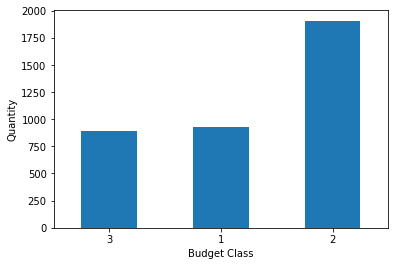

In [16]:
ax = Movies['budget_class'].value_counts().sort_values(ascending=True).plot(kind='bar')
ax.set_xlabel("Budget Class")
ax.set_ylabel("Quantity")
plt.xticks(rotation="horizontal")
plt.show()

The graph is coherent with the divions we made

##### Let's check the distribution of budgets:

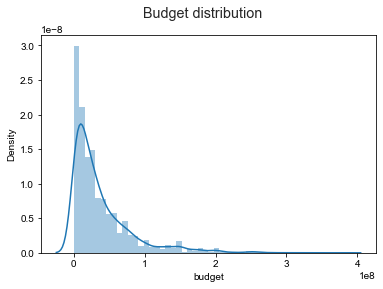

Budget skewness:  2.218841914564844


In [17]:

sns.distplot(Movies['budget'])
sns.set(rc={'figure.figsize':(15,6)})
plt.suptitle('Budget distribution')
plt.show()

print("Budget skewness: ",Movies['budget'].skew())


The distribution is skewed, this could be a problem for the machine learning algorithm, hance we try to adjust the skewness of the distribution

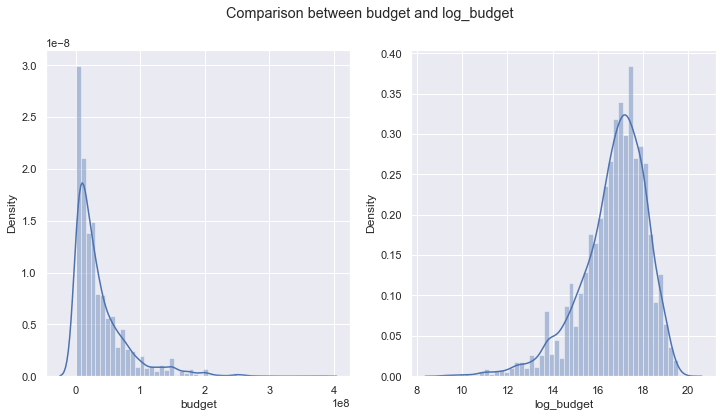

In [18]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
Movies['log_budget'] = np.log1p(Movies['budget'])
sns.distplot(Movies['budget'],ax=ax1)
sns.distplot(Movies['log_budget'],ax=ax2)
fig.suptitle("Comparison between budget and log_budget")
plt.show()




In [19]:
print("Skewness before log : {} and Skewness after log : {}".format(Movies['budget'].skew(),Movies['log_budget'].skew()))

Skewness before log : 2.218841914564844 and Skewness after log : -1.0986633306234408


## Revenues ##

In [20]:
print('Movies with 0$ revenues: ',Movies[Movies['revenue'] == 0].shape[0])

Movies with 0$ revenues:  1420


Mettiamo anche questi a Nan

In [21]:
for row in Movies.index:
    if (Movies.loc[row, 'revenue'] == 0):
        Movies.loc[row, 'revenue'] = np.nan

In [22]:
Movies['revenue'].isna().sum()

1420

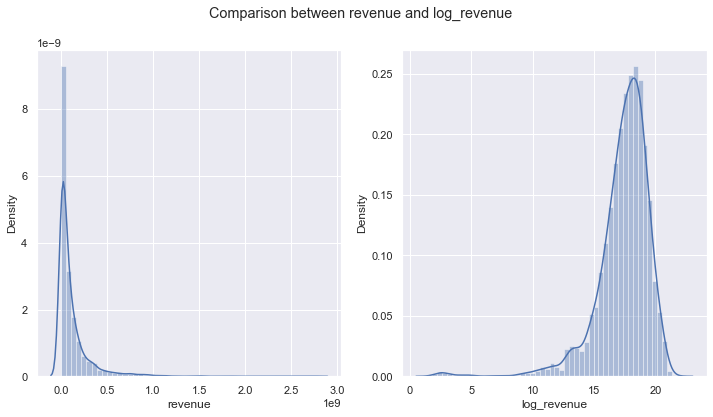

In [23]:
Movies['log_revenue'] = np.log1p(Movies['revenue'])
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

sns.distplot(Movies['revenue'],ax=ax1)
sns.distplot(Movies['log_revenue'],ax=ax2)
fig.suptitle("Comparison between revenue and log_revenue")
plt.show()

In [24]:
print("Skewness before log : {} and Skewness after log : {}".format(Movies['revenue'].skew(),Movies['log_revenue'].skew()))

Skewness before log : 3.884930617583634 and Skewness after log : -2.405363465644692


## Score ##

Vogliamo eliminare quei film che hanno una percentuale di vote_count(voti dati) bassa,perché andrebbe a creare degli squilibri,
visto che un film votato 8,però da 5 persone,non é affidabile

In [25]:
#TODO: potremmo anche fare questo lavoro sul dataset di partenza aggiungendo una colonna, metà avranno nan
C = Movies['vote_average'].mean()
C
m = Movies['vote_count'].quantile(0.5)

for i in Movies.index:
    if Movies.loc[i,'vote_count'] <= m:
        Movies.loc[i,'vote_count'] = np.nan
    else:
        pass

    
q_movies = Movies[['id','vote_count','vote_average']]

Riteniamo importante che la media dei voti sia pesata con il numero di voti che la generano, per fare questo usiamo la formula consigliata dal sito IMBD e togliamo le due colonne vote_average e vote_count per unirle in una che le metta insieme

In [26]:
#Rating pesato
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [27]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

q_movies.drop(['vote_average','vote_count'],inplace=True,axis='columns')

#Merge dei dataframe,ora Movies ha anche la colonna Score",
Movies = pd.merge(Movies,q_movies,on='id',how='inner')

Movies.shape

(4795, 21)

Abbiamo eliminato dei film (in q_movies), quelli con troppi pochi voti per poter essere presi in considerazione per quanto riguarda il voto ricevuto e abbiamo poi riunito i due dataframe,cosi ora Movies ha anche la colonna score

## Profitti ##

Misuriamo i ricavi rispetto al budget tramite una funzione,e aggiungiamo una nuova colonna chiamata 'profit_perc' contente i risultati

In [28]:
def calculate_profit_perc(x):
    if (x.revenue>0) and (x.budget>0):
        return ((x.revenue-x.budget)/x.budget)*100
    

In [29]:
Movies = Movies.assign(profit_perc = lambda x: x.budget)
for row in Movies.index:
    Movies.loc[row,'profit_perc'] =  calculate_profit_perc(Movies.loc[row])

Definiamo funzione che dato un genere calcola la media dei profitti dei film che lo contengono

In [30]:
temp = Movies
temp.dropna(axis=0,inplace=True)

In [31]:
#Quanti film ci sono per genere con profitto diverso da Nan
def films_per_genres(genre):
    count = 0
    for row in temp.index:
        if (genre in temp.loc[row, 'genres'] and (temp.loc[row,'profit_perc'] != np.nan)):
            count+=1
    return count


#Profitto per genere
def genre_average_profits(genre):
    sum = 0
    count = 0
    for row in temp.index:
        if (genre in temp.loc[row, 'genres'] and (temp.loc[row,'profit_perc'] != np.nan)):
            sum += temp.loc[row, 'profit_perc']
            count+=1
    return sum/count



In [32]:
genres=[]
for row in temp.index:
    _gen = temp.loc[row,'genres']
    for g in _gen:
        if g not in genres:
            genres.append(g)

profits=[]
for g in genres:
    profits.append(genre_average_profits(g))
            
print("Profitto associato ad ogni genere:")
for i in range(0,len(genres)):
    print('\t',genres[i], " has a mean profit of ", profits[i])

Profitto associato ad ogni genere:
	 Action  has a mean profit of  304.0197925073328
	 Adventure  has a mean profit of  410.4735995190337
	 Fantasy  has a mean profit of  333.67295828967104
	 Science Fiction  has a mean profit of  357.4043673286655
	 Crime  has a mean profit of  282.76597145297075
	 Drama  has a mean profit of  569.8323474101483
	 Thriller  has a mean profit of  561.0186645149466
	 Animation  has a mean profit of  649.5884284948968
	 Family  has a mean profit of  540.9222601790862
	 Western  has a mean profit of  637.414451302206
	 Comedy  has a mean profit of  504.77933325142254
	 Romance  has a mean profit of  536.4716202005993
	 Horror  has a mean profit of  8295.371058234967
	 Mystery  has a mean profit of  9041.087375998894
	 History  has a mean profit of  301.421669610385
	 War  has a mean profit of  468.05337132789015
	 Music  has a mean profit of  813.5654206579787
	 Documentary  has a mean profit of  6119.964841509324


Possiamo osservare come alcuni film abbiano un profitto molto alto,questo é dato dal fatto che ad esempio i film Horror hanno guadagnato molto e ve ne sono pochi all'interno del dataset,vediamo quindi le cardinalità di ogni genere

In [33]:
films = []
for el in genres:
    films.append(films_per_genres(el))
    
print("I generi presenti nel dataframe sono:")
for genre,film in zip(genres,films):
    print(genre,film)

I generi presenti nel dataframe sono:
Action 688
Adventure 519
Fantasy 277
Science Fiction 339
Crime 373
Drama 835
Thriller 687
Animation 143
Family 258
Western 31
Comedy 704
Romance 323
Horror 241
Mystery 195
History 77
War 73
Music 50
Documentary 9


I Documentari ad esempio sono molti pochi rispetto al totale dei film ed hanno un profitto percentuale pari a 6119 circa ,quindi per il motivo citato in precedenza sbilanciano di molto i conti. Possiamo permetterci di escluderli,visto che sono solamente 9

In [34]:
genres.remove(genres[-1])
profits.remove(profits[-1])

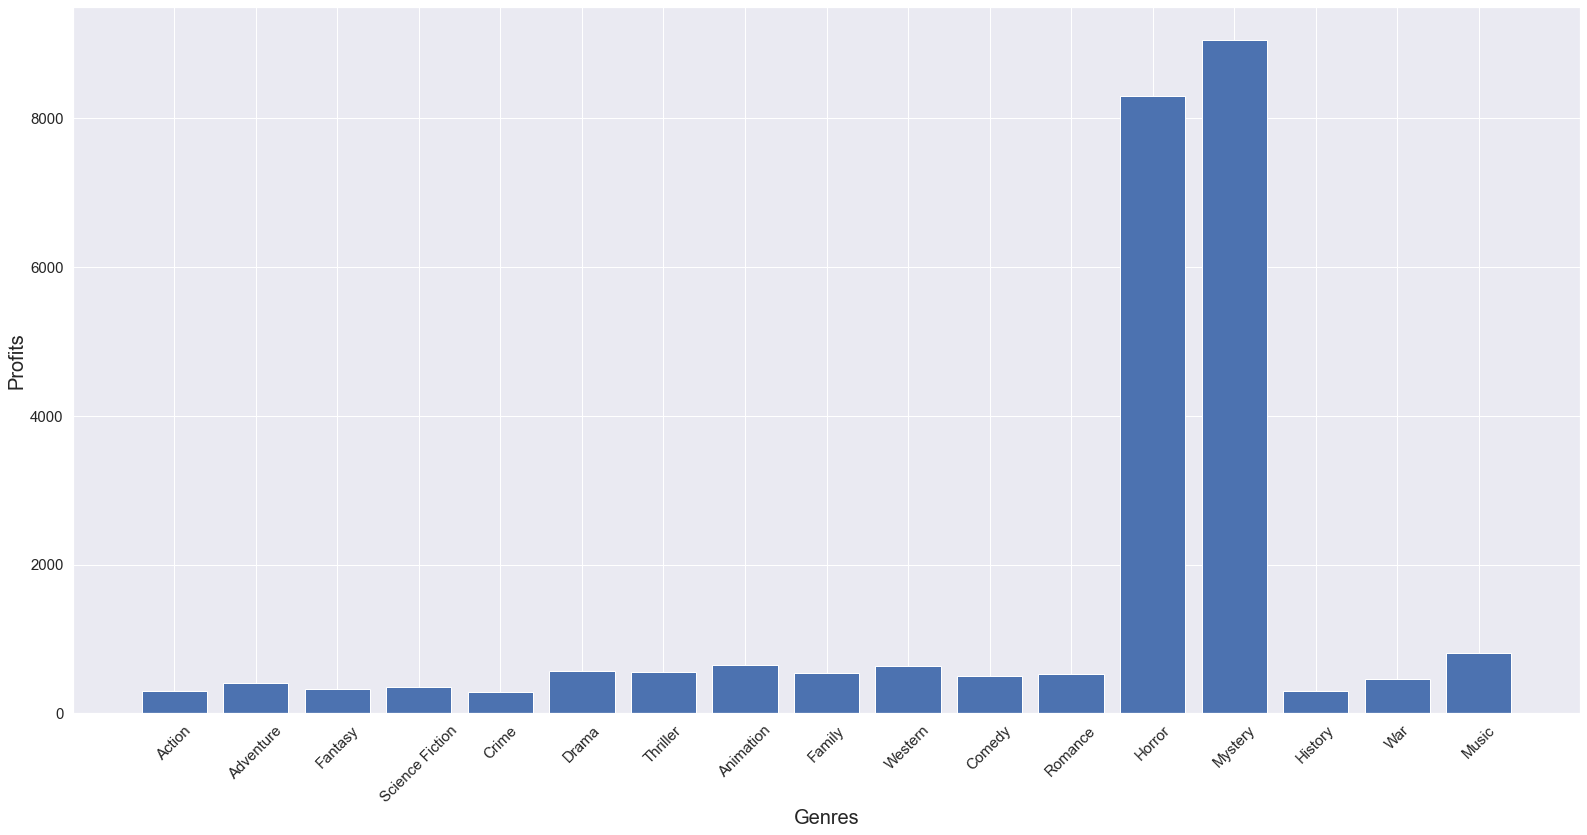

In [35]:
fig, ax = plt.subplots()
ax.bar(genres,profits)
fig.set_figwidth(27)
fig.set_figheight(13)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Genres", fontsize=20)
plt.ylabel("Profits", fontsize=20)
plt.show()

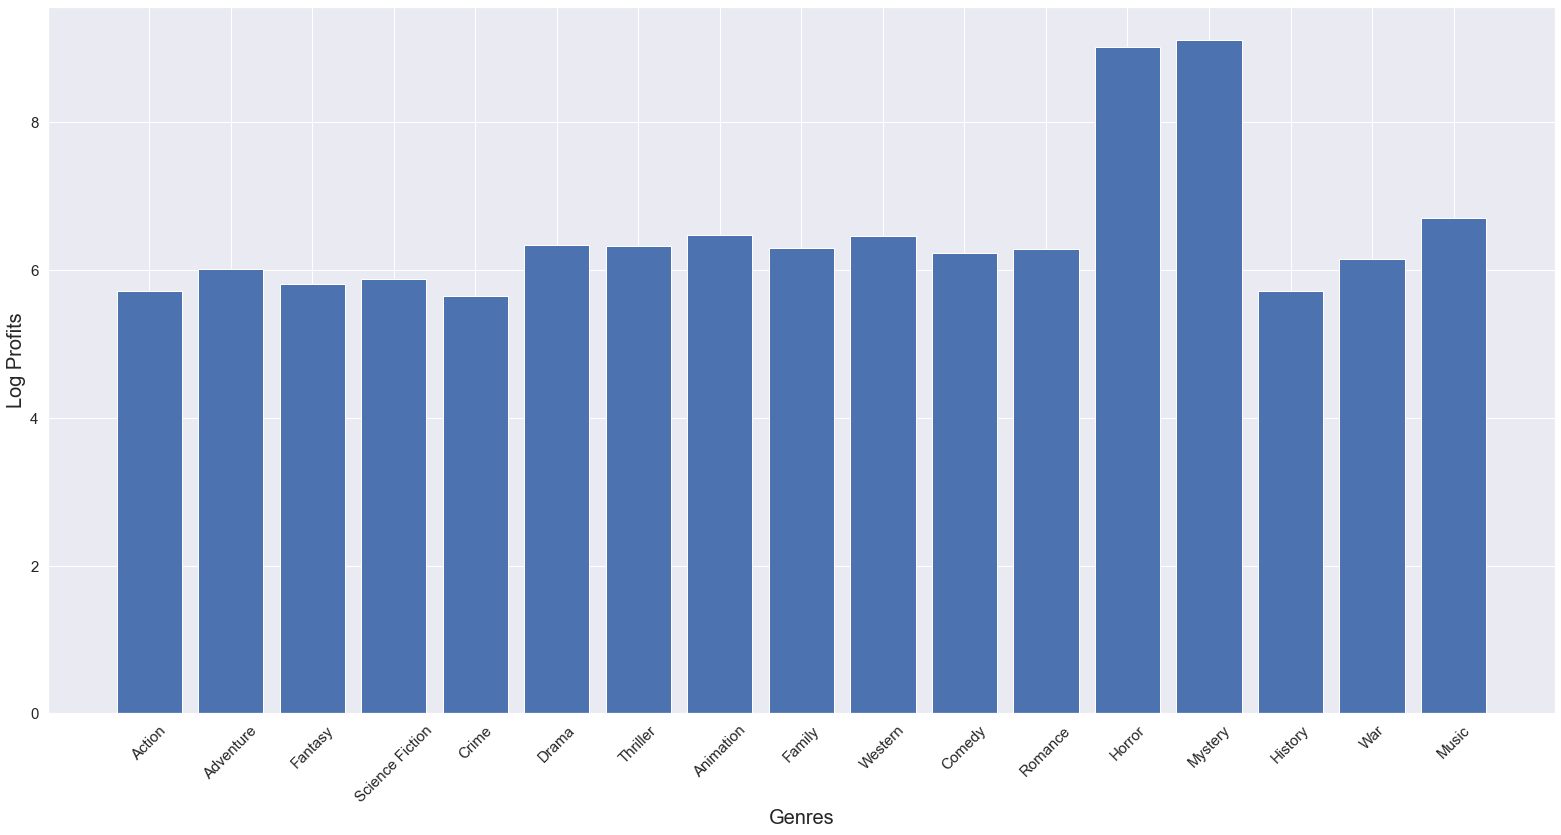

In [36]:
log_profit = np.log1p(profits)
fig, ax = plt.subplots()
ax.bar(genres,log_profit)
fig.set_figwidth(27)
fig.set_figheight(13)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Genres", fontsize=20)
plt.ylabel("Log Profits", fontsize=20)
plt.show()

## Keywords ##

Vediamo quali sono le parole più frequenti presenti tra le keywords

In [37]:
""" from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
#nltk.download("stopwords")
from nltk.tokenize import word_tokenize


plt.subplots(figsize=(12,12))
stop_words=set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

Movies['keywords'].dropna(inplace=True)
Movies['keywords'] = Movies['keywords'].astype(str)
words=Movies['keywords'].apply(nltk.word_tokenize)
word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=2000,stopwords=STOPWORDS, max_font_size= 60,width=1000,height=600)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show() """

' from wordcloud import WordCloud, STOPWORDS\nimport nltk\nfrom nltk.corpus import stopwords\n#nltk.download("stopwords")\nfrom nltk.tokenize import word_tokenize\n\n\nplt.subplots(figsize=(12,12))\nstop_words=set(stopwords.words(\'english\'))\nstop_words.update(\',\',\';\',\'!\',\'?\',\'.\',\'(\',\')\',\'$\',\'#\',\'+\',\':\',\'...\',\' \',\'\')\n\nMovies[\'keywords\'].dropna(inplace=True)\nMovies[\'keywords\'] = Movies[\'keywords\'].astype(str)\nwords=Movies[\'keywords\'].apply(nltk.word_tokenize)\nword=[]\nfor i in words:\n    word.extend(i)\nword=pd.Series(word)\nword=([i for i in word.str.lower() if i not in stop_words])\nwc = WordCloud(background_color="black", max_words=2000,stopwords=STOPWORDS, max_font_size= 60,width=1000,height=600)\nwc.generate(" ".join(word))\nplt.imshow(wc)\nplt.axis(\'off\')\nfig=plt.gcf()\nfig.set_size_inches(10,10)\nplt.show() '

## Release Date ##

In [38]:
#Convertiamo le release date in formato datetime
temp['release_date'] = pd.to_datetime(temp['release_date'])
temp['release_year'] = temp['release_date'].dt.year
temp['release_month'] = temp['release_date'].dt.month
temp['release_day'] = temp['release_date'].dt.dayofweek

In [39]:
temp['decades'] = temp['release_date'].apply(lambda x : (x.year // 10)*10)

Quantità di film rilasciati nei diversi mesi dell' anno

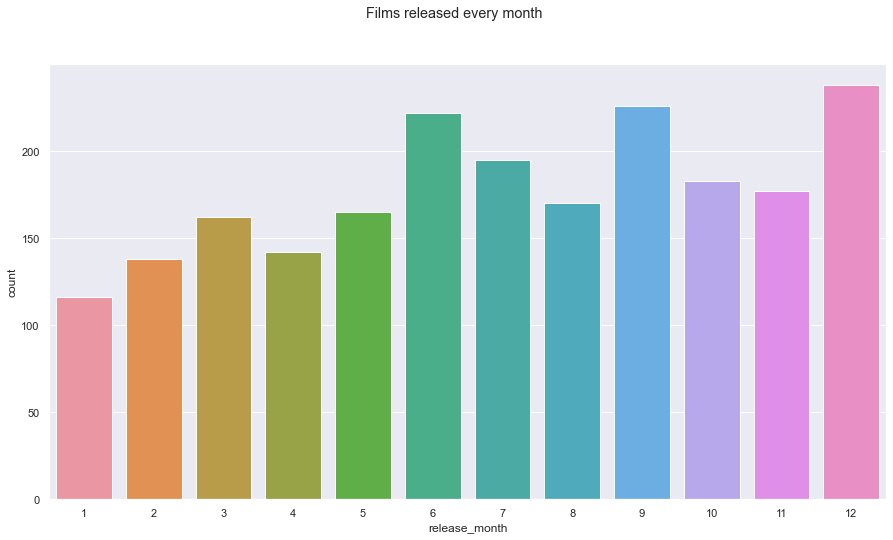

In [40]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x='release_month',data=temp)
plt.suptitle("Films released every month")
plt.show()

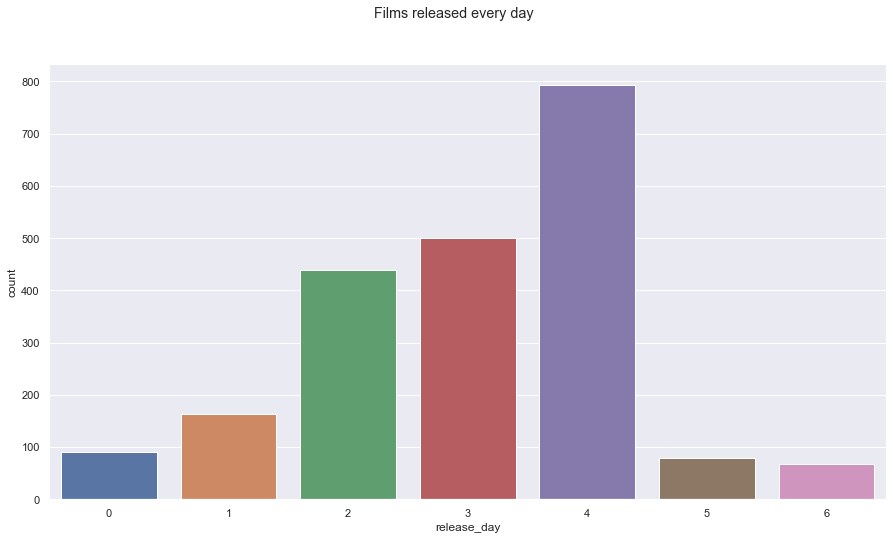

In [41]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x='release_day',data=temp)
plt.suptitle("Films released every day")
plt.show()

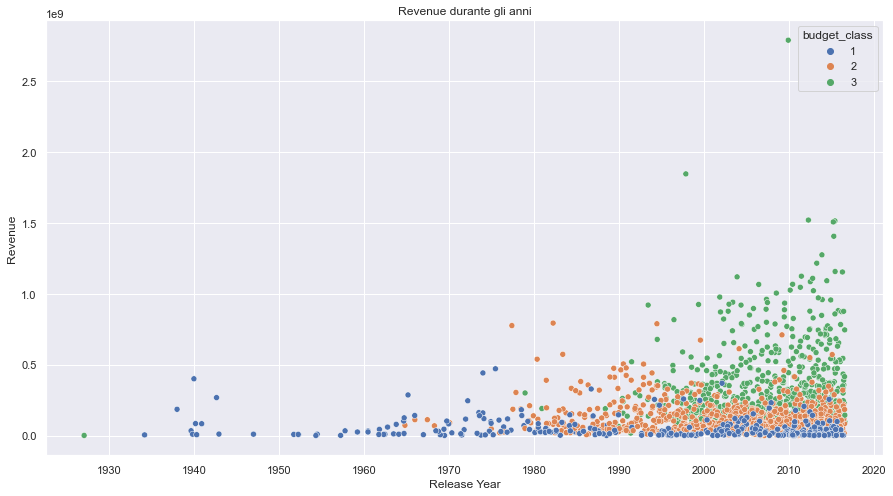

In [42]:
ax = sns.scatterplot(x="release_date",y="revenue",data=temp,hue="budget_class")
sns.set(rc = {'figure.figsize':(6,6)})
ax.set_title("Revenue durante gli anni")
ax.set_xlabel("Release Year")
ax.set_ylabel("Revenue")
plt.show()

Il grafico sopra mostra come le revenues siano aumentate nel tempo,cosi come i budget investiti

In [43]:
d2 = temp.groupby(['release_month'])['revenue'].mean()
data = [go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y')]
layout = go.Layout(dict(title = "Average revenue per month",
                  xaxis = dict(title = 'Month'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

In [44]:
d2 = temp.groupby(['release_day'])['revenue'].mean()
data = [go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y')]
layout = go.Layout(dict(title = "Average revenue per Day",
                  xaxis = dict(title = 'Day'),
                  yaxis2=dict(title='Average revenue', overlaying='y', side='right')
                  ),legend=dict(
                orientation="v"))
py.iplot(dict(data=data, layout=layout))

## Popularity ##

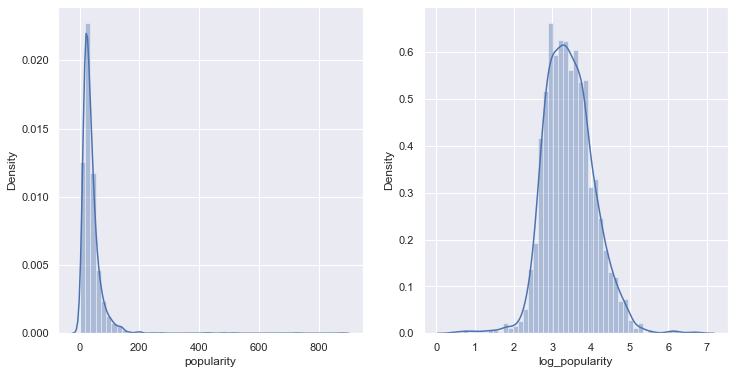

In [45]:
temp['log_popularity'] = np.log(temp['popularity'])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))

sns.distplot(temp['popularity'],ax=ax1)
sns.distplot(temp['log_popularity'],ax=ax2)

plt.show()


In [46]:
print("Skewness before log : {} and Skewness after log : {}".format(temp['popularity'].skew(),temp['log_popularity'].skew()))

Skewness before log : 9.382230160157636 and Skewness after log : 0.27324869836877164


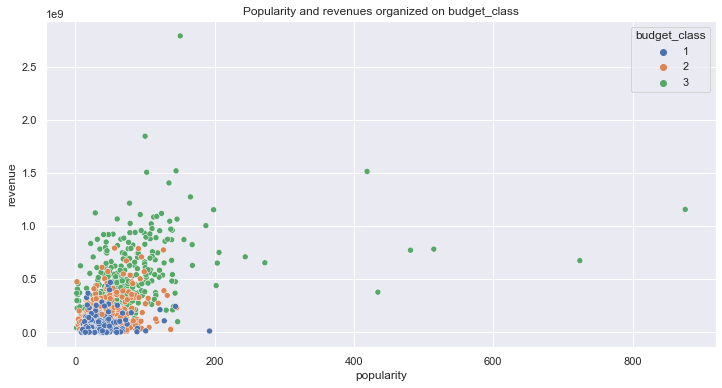

In [47]:
sns.set(rc = {'figure.figsize':(12,6)})
ax = sns.scatterplot(x='popularity',y='revenue',data=temp,hue="budget_class")
ax.set_title("Popularity and revenues organized on budget_class")
plt.show()

# Cast e Direttori #

In [48]:
temp.columns

Index(['budget', 'genres', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime', 'status',
       'tagline', 'vote_average', 'vote_count', 'budget_class', 'log_budget',
       'log_revenue', 'score', 'profit_perc', 'release_year', 'release_month',
       'release_day', 'decades', 'log_popularity'],
      dtype='object')

In [49]:
cast = pd.read_csv("tmdb_5000_credits.csv")

In [50]:
feat_to_manage = ['cast','crew']
for f in feat_to_manage:
    cast[f] = cast[f].apply(literal_eval)

#Two functions that convert directors and actors from json to list-str
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_actors(x): #TODO:si può usare senza fare modifiche get_name?
    if isinstance(x, list):
        names = [i['name'] for i in x]
        
        return names
    return []

In [51]:
#Create two new column correctly formatted
cast['director'] = cast['crew'].apply(get_director)
cast['actors'] = cast['cast'].apply(get_actors)

In [52]:
#Drop old columns
cast.drop('cast',inplace=True,axis=1)
cast.drop('crew',inplace=True,axis=1)
cast.drop('title',inplace=True,axis=1)

In [53]:
#rename Movie_id to id, preparing for the merge
cast = cast.rename(columns={'movie_id': 'id'})

#Merge two dataframe Movies,cast
full_df = pd.merge(temp,cast,on="id",how="inner")
recommend_df = full_df.copy()

## Attori ##

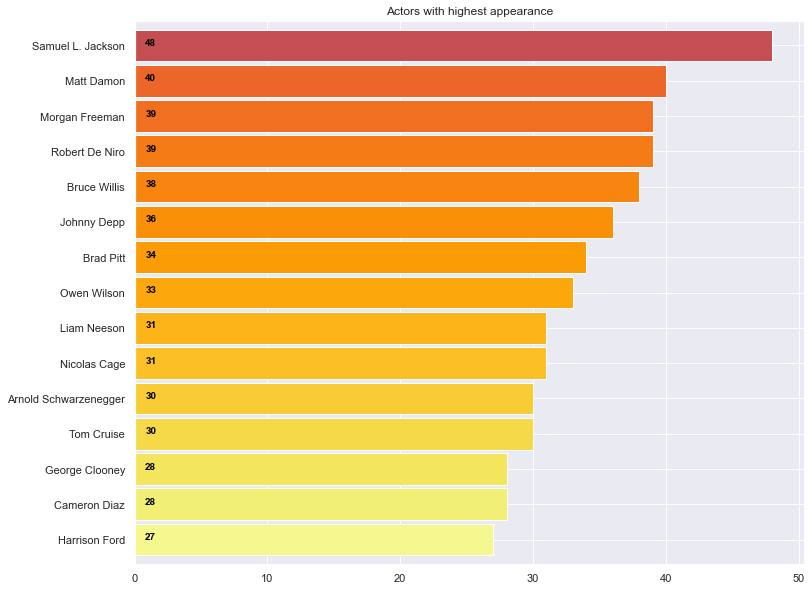

In [54]:
actors=[]


for i in full_df['actors']:
    actors.extend(i)

actors = list(filter(None, actors))


plt.subplots(figsize=(12,10))
ax=pd.Series(actors).value_counts()[:15].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno_r',40))
for i, v in enumerate(pd.Series(actors).value_counts()[:15].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='black',weight='bold')

plt.title('Actors with highest appearance')
ax.patches[14].set_facecolor('r')
plt.show()

## Registi ##

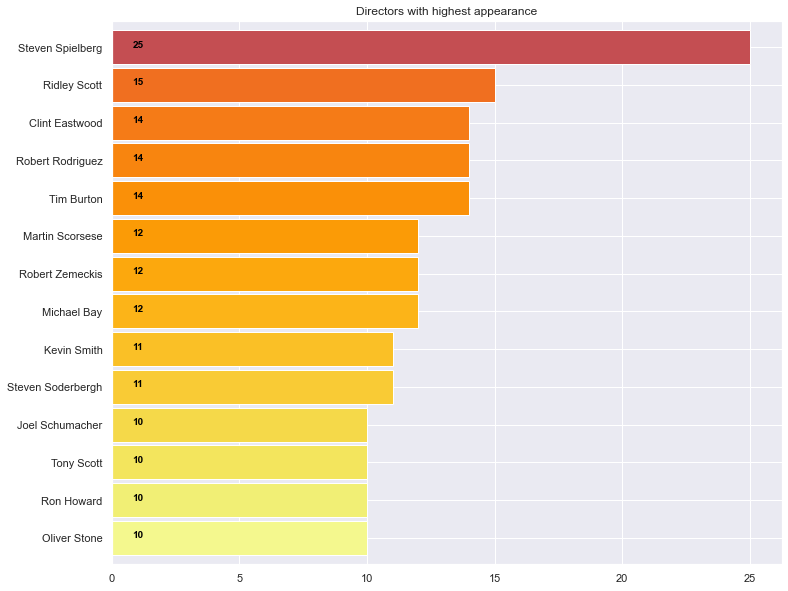

In [55]:
directors=[]


for i in full_df['director']:
    directors.append(i)

directors = list(filter(None, directors))


plt.subplots(figsize=(12,10))
ax=pd.Series(directors).value_counts()[:14].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('inferno_r',40))
for i, v in enumerate(pd.Series(directors).value_counts()[:14].sort_values(ascending=True).values): 
    ax.text(.8, i, v,fontsize=10,color='black',weight='bold')

plt.title('Directors with highest appearance')
ax.patches[13].set_facecolor('r')
plt.show()

Calcoliamo Score medio per i registi più presenti(>= 10)

In [56]:
#Filter the directors with made films >= 10,then calculate the mean scores
#Dovrebbe fare lo stesso lavoro di score_for_director applicato poi alla hashmap, quindi ho rimosso entrambe

director_group = full_df.groupby('director').filter(lambda x : len(x) >= 10)
mean_scores = director_group.groupby('director')['score'].mean().sort_values(ascending=False).reset_index(name="score")

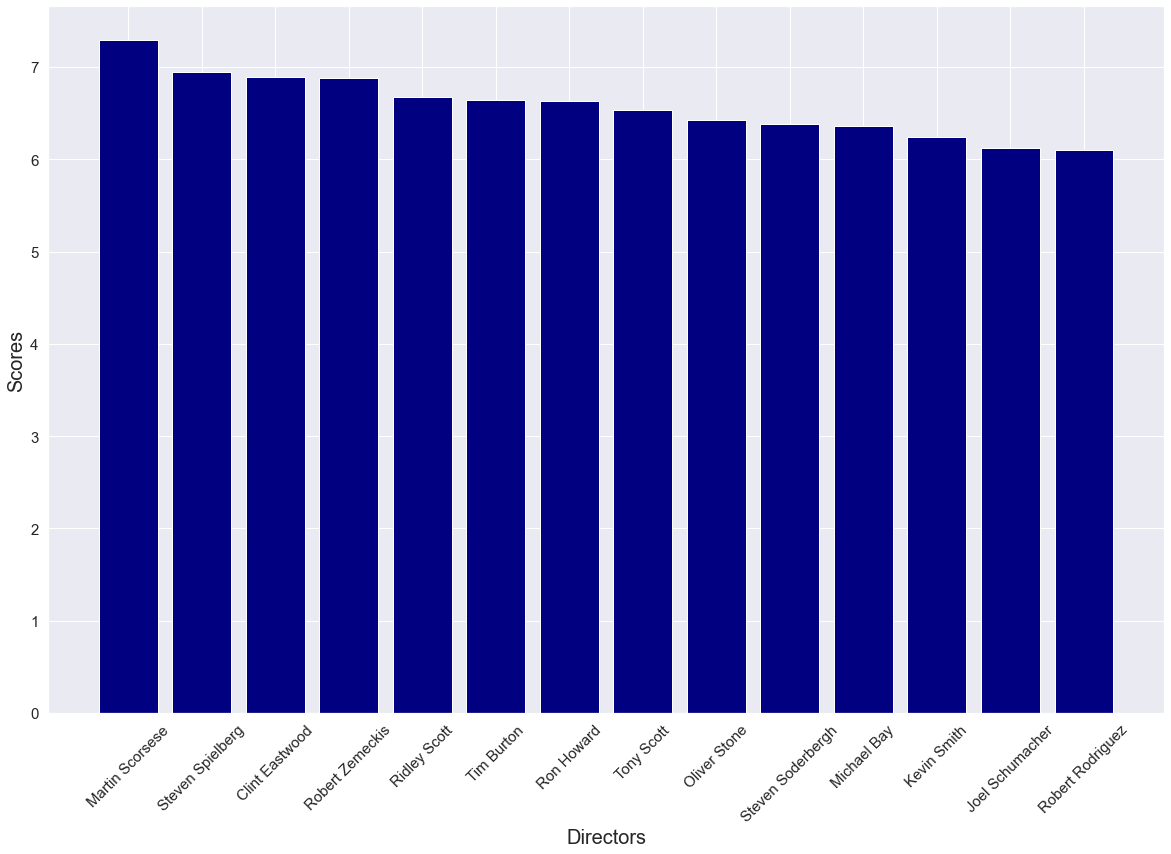

In [57]:
fig, ax = plt.subplots()
ax.bar(mean_scores['director'],mean_scores['score'],color='navy')
fig.set_figwidth(20)
fig.set_figheight(13)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Directors", fontsize=20)
plt.ylabel("Scores", fontsize=20)
plt.show()

# Predizioni #

## Revenue ##

In [62]:
supertest = temp.copy()
def prepare(temp):
    temp['_budget_runtime_ratio'] = temp['budget']/temp['runtime'] 
    temp['_budget_popularity_ratio'] = temp['budget']/temp['popularity']
    temp['_budget_year_ratio'] = temp['budget']/(temp['release_year']*temp['release_year'])
    temp['_releaseYear_popularity_ratio'] = temp['release_year']/temp['popularity']
    temp['_releaseYear_popularity_ratio2'] = temp['popularity']/temp['release_year']
    temp['_year_to_log_budget'] = temp['release_year'] / temp['log_budget']
    temp['_year_to_log_popularity'] = temp['release_year'] / temp['log_popularity']

    ##temp['has_homepage'] = 0
    ##temp.loc[pd.isnull(temp['homepage']) ,"has_homepage"] = 1
    
    ##temp['isTaglineNA'] = 0
    ##temp.loc[temp['tagline'] == 0 ,"isTaglineNA"] = 1 
    
    ##temp['isTitleDifferent'] = 1
    ##temp.loc[ temp['original_title'] == temp['title'] ,"isTitleDifferent"] = 0
    ##temp['isMovieReleased'] = 1
    ##temp.loc[ temp['status'] != "Released" ,"isMovieReleased"] = 0 

    temp['original_title_letter_count'] = temp['original_title'].str.len() 
    temp['original_title_word_count'] = temp['original_title'].str.split().str.len() 
    #temp['title_word_count'] = temp['title'].str.split().str.len()
    temp['overview_word_count'] = temp['overview'].str.split().str.len()
    temp['tagline_word_count'] = temp['tagline'].str.split().str.len()
    #temp['meanruntimeByYear'] = temp.groupby("release_year")["runtime"].aggregate('mean')
    #temp['meanPopularityByYear'] = temp.groupby("release_year")["popularity"].aggregate('mean')
    #temp['meanBudgetByYear'] = temp.groupby("release_year")["budget"].aggregate('mean')

    return temp
new_temp= prepare(supertest)


In [63]:
""" new_temp['genres'] = new_temp['genres'].apply(lambda x : x[0] if len(x) > 0 else None)
new_temp['keywords'] = new_temp['keywords'].apply(lambda x : x[0] if len(x) > 0 else None)
new_temp['production_countries'] = new_temp['production_countries'].apply(lambda x : x[0] if len(x) > 0 else None)
new_temp['production_companies'] = new_temp['production_companies'].apply(lambda x : x[0] if len(x) > 0 else None) """
new_temp.head(1)




,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,tagline,vote_average,vote_count,budget_class,log_budget,log_revenue,score,profit_perc,release_year,release_month,release_day,decades,log_popularity,_budget_runtime_ratio,_budget_popularity_ratio,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,_year_to_log_budget,_year_to_log_popularity,original_title_letter_count,original_title_word_count,overview_word_count,tagline_word_count
0,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[US, GB]",2009-12-10,2.787965e+09,162.0,Released,Enter the World of Pandora.,7.2,11800.0,3,19.283571,21.748578,7.1783,1076.356577,2009,12,3,2000,5.013548,1.462963e+06,1.575404e+06,58.720328,13.354376,0.074882,104.18195,400.714207,6,1,28,5


In [64]:
import re
def format_prod_count(list):
    for el in list:
        el = re.sub('[^A-Za-z0-9_]+', '', str(el))

new_temp['production_companies'] = new_temp['production_companies'].apply(lambda x:format_prod_count(x))
#new_temp['production_companies'] = new_temp['production_companies'].apply(lambda x:[re.sub('[^A-Za-z0-9_]+', '', str(el))] for el in x)

In [65]:
#genres
df=pd.DataFrame( {'genres': new_temp['genres']})
df= pd.get_dummies(df.genres.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)

#keywords
df=pd.DataFrame( {'keywords': new_temp['keywords']})
df= pd.get_dummies(df.keywords.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)

#production companies
df=pd.DataFrame( {'production_companies': new_temp['production_companies']})
df= pd.get_dummies(df.production_companies.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)

#production countries
df=pd.DataFrame( {'production_countries': new_temp['production_countries']})
df= pd.get_dummies(df.production_countries.apply(pd.Series).stack()).sum(level=0)
new_temp = pd.concat([new_temp,df],axis = 1)


new_temp.head(2)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,tagline,vote_average,vote_count,budget_class,log_budget,log_revenue,score,profit_perc,release_year,release_month,release_day,decades,log_popularity,_budget_runtime_ratio,_budget_popularity_ratio,_budget_year_ratio,_releaseYear_popularity_ratio,_releaseYear_popularity_ratio2,_year_to_log_budget,_year_to_log_popularity,original_title_letter_count,original_title_word_count,overview_word_count,tagline_word_count,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western,15th century,16th century,17th century,18th century,1910s,1930s,1940s,1950s,1960s,1970s,1980s,1990s,19th century,2000 ad,20th century,21st century,25th century,2nd century,3d,abandoned mine,abduction,abolitionist,abortion,abraham lincoln,absorbing power,absurdism,abuse,abusive father,abusive husband,acapella,accident,accountant,acid,action,action hero,action heroine,activist,actor,actress,adaptation,addicted,addiction,admiration,admissions,adolescence,adolescent boy,adolf hitler,adopted child,adoption,adoptive father,adoptive mother,adrenalin,adrenaline junkie,adult animation,adult as a child,adultery,advancement,adventure,adventurer,adversary,advertising,advertising executive,advertising expert,advice,aerial combat,aerial shot,aerobics,affair,affection,afghanistan,africa,african,african american,african american child,african american comedy,aftercreditsstinger,afterlife,age difference,agent,agent coulson,aggression,aggression by animal,aggression by plant,aggressive,aging,agnostic,agriculture,aids,ailul al aswad,air,air conditioner,air controller,air force,air force one,air traffic control,aircraft carrier,airline pilot,airplane,airplane accident,airplane crash,airplane hijack,airport,airport lounge,airport security,al capone,al qaeda,alabama,alarm,alarm clock,alaska,albania,albanian,alberta canada,albino,alcatraz,alcohol,alcohol abuse,alcoholic,alcoholic drink,alcoholism,alexander the great,alice in wonderland,alien,alien abduction,alien attack,alien contact,alien dna,alien encounter,alien friendship,alien infection,alien invasion,alien life-form,alien parasites,alien phenomenons,alien planet,alien possession,alien queen,alien race,alien space craft,alien technology,alien teenager,alienation,all girl,all girl band,all male cast,allan quatermain,allegory,allergy,alley,alliance,allies,alligator,almanac,alone,alps,als,altar,alter ego,altering history,alternate dimension,alternate history,alternate reality,alternative,alternative reality,alzheimer's disease,amateur,amateur detective,amateur radio,amateur theater,amazon,amazon rainforest,amazon river,ambassador,ambiguous ending,ambition,ambulance,ambush,amelia earhart,american,american way of life,american abroad,american civil war,american dream,american flag,american football,american football coach,american football player,american football stadium,american president,american spy,amish,amnesia,amputee,amsterdam,amusement park,anaconda,analyst,anarchic comedy,anarchist,anchor,anchorage alaska,ancient,ancient astronaut,ancient china,ancient civilization,ancient egypt,ancient evil,ancient greece,ancient rome,ancient world,android,angel,angels,anger,anger issues,anger management,angkor wat,angry,angry mob,animal,animal attack,animal death,animal experimentation,animal horror,animal in cast credits,animal killing,animal lead,animal lover,animal protection,animal sidekick,animate tree,animated credits,animated flashback,animated map,animated sequence,animation,anime,ankle holster,annabelle,anne frank,anonymity,anonymous letter,another dimension,ant,ant's nest,ant-hill,antarctic,antarctica,anthropomorphism,anti authority,anti hero,anti semitism,anti terror,anti war,anti-authoritarian upbringing,anti-christ,anti-communism,antidote,antigen,antihero,antiquary,antique,antisocial pers

In [ ]:
new_temp.head(1)

In [66]:
drop_columns=['status','release_date','tagline', 'overview', 'original_title','original_language','id','revenue','profit_perc','genres', 'keywords','production_companies','production_countries']
new_temp= new_temp.drop(drop_columns, axis=1)            

In [67]:
Movies.head(4)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,status,tagline,vote_average,vote_count,budget_class,log_budget,log_revenue,score,profit_perc,release_year,release_month,release_day,decades,log_popularity
0,237000000.0,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[US, GB]",2009-12-10,2.787965e+09,162.0,Released,Enter the World of Pandora.,7.2,11800.0,3,19.283571,21.748578,7.178300,1076.356577,2009,12,3,2000,5.013548
1,300000000.0,"[Adventure, Fantasy, Action]",285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[US],2007-05-19,9.610000e+08,169.0,Released,"At the end of the world, the adventure begins.",6.9,4500.0,3,19.519293,20.683485,6.859802,220.333333,2007,5,5,2000,4.935068
2,245000000.0,"[Action, Adventure, Crime]",206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[GB, US]",2015-10-26,8.806746e+08,148.0,Released,A Plan No One Escapes,6.3,4466.0,3,19.316769,20.596199,6.289626,259.459024,2015,10,0,2010,4.676344
3,250000000.0,"[Action, Crime, Drama, Thriller]",49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[US],2012-07-16,1.084939e+09,165.0,Released,The Legend Ends,7.6,9106.0,3,19.336971,20.804790,7.561937,333.975640,2012,7,0,2010,4.721289


In [69]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)

In [ ]:
# Formating for modeling
y = new_temp['log_revenue']
X = new_temp.drop(['log_revenue'], axis=1)
#y = np.log1p(new_temp['revenue']) proviamo senza
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.2,
         "verbosity": -1}

lgb_model = lgb.LGBMRegressor(**params, n_estimators = 10000, nthread = 4, n_jobs = -1)
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict(X_valid)


In [ ]:
mse = mean_squared_error(y_valid, y_pred)
mse

In [ ]:
mae = mean_absolute_error(y_valid, y_pred)
mae

In [ ]:
from sklearn.metrics import r2_score 
r2 = r2_score(y_valid,y_pred)
r2

In [ ]:
df = pd.DataFrame({'Real Values': y_valid, 'Predicted Values': y_pred})
df

In [ ]:
plt.scatter(y_valid, y_pred)
tmp = [min(np.concatenate((y_train,y_valid))),
       max(np.concatenate((y_train,y_valid)))]
plt.plot(tmp,tmp,'r')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

## Score ##

Convertiamo tutte le feature categoriche in binario

In [ ]:
def binary(genre_list):
    binaryList = []
    
    for genre in genres:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
full_df['genres_bin'] = full_df['genres'].apply(lambda x: binary(x))
full_df['genres_bin'].head()

In [ ]:
for i,j in zip(full_df['actors'],full_df.index):
    list2=[]
    list2=i[:4]
    full_df.loc[j,'actors']=str(list2)
full_df['actors']=full_df['actors'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['actors']=full_df['actors'].str.split(',')
for i,j in zip(full_df['actors'],full_df.index):
    list2=[]
    list2=i
    list2.sort()
    full_df.loc[j,'actors']=str(list2)
full_df['actors']=full_df['actors'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['actors']=full_df['actors'].str.split(',')

In [ ]:
full_df['actors'].head(3)

In [ ]:
actor_list=[]
for row in full_df.index:
    _actors = full_df.loc[row,'actors']
    for g in _actors:
        if g not in actor_list:
            actor_list.append(g)


def binary(cast_list):
    binaryList = []
    
    for genre in actor_list:
        if genre in cast_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
full_df['actors_bin'] = full_df['actors'].apply(lambda x: binary(x))
full_df['actors_bin'].head(3)


In [ ]:
for i,j in zip(full_df['director'],full_df.index):
    list2=[]
    list2=i[:4]
    full_df.loc[j,'director']=str(list2)
full_df['director']=full_df['director'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['director']=full_df['director'].str.split(',')
for i,j in zip(full_df['director'],full_df.index):
    list2=[]
    list2=i
    list2.sort()
    full_df.loc[j,'director']=str(list2)
full_df['director']=full_df['director'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['director']=full_df['director'].str.split(',')

In [ ]:
director_list=[]
for row in full_df.index:
    _actors = full_df.loc[row,'director']
    for g in _actors:
        if g not in director_list:
            director_list.append(g)

def binary(directors):
    binaryList = []
    
    for direct in director_list:
        if direct in directors:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
full_df['director_bin'] = full_df['director'].apply(lambda x: binary(x))
full_df['director_bin'].head(3)

In [ ]:
full_df['keywords']=full_df['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
full_df['keywords']=full_df['keywords'].str.split(',')
for i,j in zip(full_df['keywords'],full_df.index):
    list2=[]
    list2=i[:4]
    full_df.loc[j,'keywords']=str(list2)
full_df['keywords']=full_df['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['keywords']=full_df['keywords'].str.split(',')
for i,j in zip(full_df['keywords'],full_df.index):
    list2=[]
    list2=i
    list2.sort()
    full_df.loc[j,'keywords']=str(list2)
full_df['keywords']=full_df['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
full_df['keywords']=full_df['keywords'].str.split(',')

In [ ]:
words_list = []
for index, row in full_df.iterrows():
    genres = row["keywords"]
    
    for genre in genres:
        if genre not in words_list:
            words_list.append(genre)

In [ ]:
def binary(words):
    binaryList = []
    
    for genre in words_list:
        if genre in words:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
full_df['words_bin'] = full_df['keywords'].apply(lambda x: binary(x))
full_df['words_bin'].head(3)

In [ ]:
full_df = full_df[(full_df['vote_average']!=0)] #removing the movies with 0 score and without drector names 
full_df = full_df[full_df['director']!='']

In [ ]:
new_id = list(range(0,full_df.shape[0]))
full_df['new_id']=new_id
full_df=full_df[['original_title','genres','vote_average','genres_bin','actors_bin','new_id','director','director_bin','words_bin']]
full_df.head()

In [ ]:
from scipy import spatial

def Similarity(movieId1, movieId2):
    a = full_df.iloc[movieId1]
    b = full_df.iloc[movieId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
    
    scoreA = a['actors_bin']
    scoreB = b['actors_bin']
    scoreDistance = spatial.distance.cosine(scoreA, scoreB)
    
    directA = a['director_bin']
    directB = b['director_bin']
    directDistance = spatial.distance.cosine(directA, directB)
    
    wordsA = a['words_bin']
    wordsB = b['words_bin']
    wordsDistance = spatial.distance.cosine(directA, directB)
    return genreDistance + directDistance + scoreDistance + wordsDistance

In [ ]:
Similarity(3,11)

In [ ]:
import operator

def whats_my_score(name):
    new_movie=full_df[full_df['original_title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected Movie: ',new_movie.original_title.values[0],'\n')
    def getNeighbors(baseMovie, K):
        distances = []
    
        for index, movie in full_df.iterrows():
            if movie['new_id'] != baseMovie['new_id'].values[0]:
                dist = Similarity(baseMovie['new_id'].values[0], movie['new_id'])
                distances.append((movie['new_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_movie, K)

    
    for neighbor in neighbors:
        avgRating = avgRating+full_df.iloc[neighbor[0]][2]  
    
    #print('\n')
    avgRating = avgRating/K
    print('The predicted rating for %s is: %f' %(new_movie['original_title'].values[0],avgRating))
    predicted = (new_movie['original_title'].values[0],avgRating)
    print('The actual rating for %s is %f' %(new_movie['original_title'].values[0],new_movie['vote_average']))
    

In [ ]:
whats_my_score('Avatar')

## Consigliati (Overview,Title) ##

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(stop_words="english")
recommend_df['overview'] = recommend_df['overview'].fillna('')
tfidf_matr = tfidf.fit_transform(recommend_df['overview'])
print(tfidf_matr)

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarity = linear_kernel(tfidf_matr,tfidf_matr)
cosine_similarity

In [ ]:
indices = pd.Series(recommend_df.index, index=recommend_df['original_title']).drop_duplicates()

In [ ]:
#Recommendation using cosine similarity
def get_recommendations(title, cosine_similarity=cosine_similarity):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_similarity[idx]))
    #print(sim_scores)
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #print(sim_scores)
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return recommend_df['original_title'].iloc[movie_indices]


In [ ]:
get_recommendations('The Avengers')

## Consigliati (Keywords,Actors,Directors,Genres)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
# Apply clean_data function to your features.
features = ['actors', 'keywords', 'director', 'genres']


for feature in features:
    recommend_df[feature] = recommend_df[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['actors']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
recommend_df['soup'] = recommend_df.apply(create_soup, axis=1)

In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(recommend_df['soup'])
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of our main DataFrame and construct reverse mapping as before
recommend_df = recommend_df.reset_index()
indices = pd.Series(recommend_df.index, index=recommend_df['original_title'])

In [ ]:
print(get_recommendations("The Godfather", cosine_sim2))

## Referenze
#LgbRegressor https://www.kaggle.com/code/somang1418/eda-lgb-xgb-modelings-with-a-cute-panda-meme <br>
#Recommendation 1-2 https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system <br>
#Score https://www.kaggle.com/code/ash316/what-s-my-score